In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from sklearn.linear_model import LinearRegression
from lib.cartpoleenv import CartPoleEnv
from lib.cartpolesystem import CartPoleSystem, Cart, Pole
from lib.motors import StepperMotor
from lib.numerical import rk4_step

In [113]:
dt = 0.01
g = 9.81
r = 0.04456
x_max = 1.15/2
l1 = 0.225
m1 = 0.0446
m = 0.2167
u_p1 = 0.00001

cart = Cart(m, 0.01, (-x_max, x_max), 0.2)
motor = StepperMotor(r, (-2.7, 2.7), 0.3, (-1.5, 1.5), 0.2)
poles = [Pole(m1, l1, u_p1)]
system = CartPoleSystem(cart, motor, poles, g)

In [114]:
df = pd.read_csv('data/r_following.csv')
print("Entries before filter: ", len(df))
df = df.dropna()
print("Entries after filter: ", len(df))
df

Entries before filter:  7488
Entries after filter:  7487


,s,d_s,theta_1,d_theta_1,u,time,T,desired_s,error_s,desired_d_s,error_d_s,desired_theta_1,error_theta_1,desired_d_theta_1,error_d_theta_1,desired_u
0,-0.255527,0.00,0.273557,0.000000e+00,0.000000,0.000000,2.313062e-03,0.000000e+00,0.00000,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
1,0.000000,0.00,3.141593,3.141593e+02,0.000000,8.147682,-2.877143e-15,0.000000e+00,0.00000,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
2,0.000000,0.00,3.141593,0.000000e+00,0.000000,8.246399,-1.089023e-18,0.000000e+00,0.00000,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
3,0.000000,0.00,-2.962117,1.794758e+01,0.000000,8.247644,1.524458e-02,0.000000e+00,0.00000,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
4,0.000000,0.00,-2.968253,-6.135923e-01,0.000000,8.256666,1.526192e-03,0.000000e+00,0.00000,0.000000e+00,0.00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,-14.259840,-2.52,-3.140059,2.584181e-37,-142.531283,83.293040,-1.549682e+00,4.235165e-21,14.28168,1.998998e-19,2.52,-8.470329e-21,3.140059,-6.776264e-19,-6.776264e-19,0.0
7483,-14.281680,-2.52,-3.140059,2.153484e-37,-142.595171,83.303014,-1.550376e+00,4.235165e-21,14.30352,1.998998e-19,2.52,-8.470329e-21,3.140059,-6.776264e-19,-6.776264e-19,0.0
7484,-14.303520,-2.52,-3.140059,1.794570e-37,-142.659059,83.313009,-1.551070e+00,4.235165e-21,14.32508,1.998998e-19,2.52,-8.470329e-21,3.140059,-6.776264e-19,-6.776264e-19,0.0
7485,-14.325080,-2.52,-3.140059,1.495475e-37,-142.722128,83.322919,-1.551755e+00,4.235165e-21,14.34664,1.998998e-19,2.52,-8.470329e-21,3.140059,-6.776264e-19,-6.776264e-19,0.0


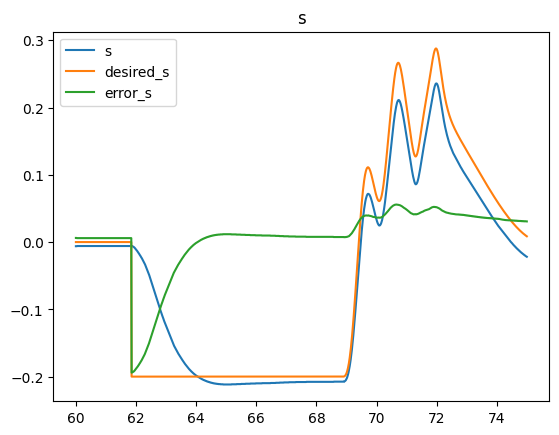

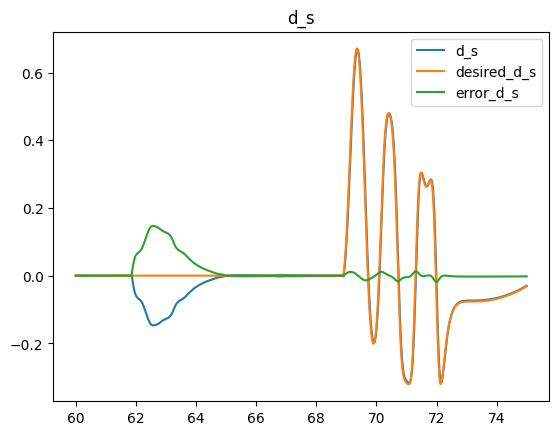

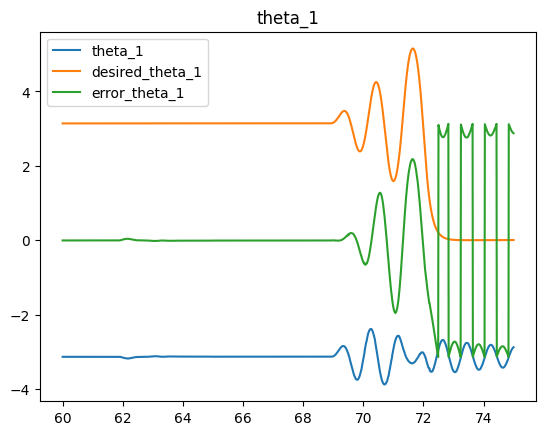

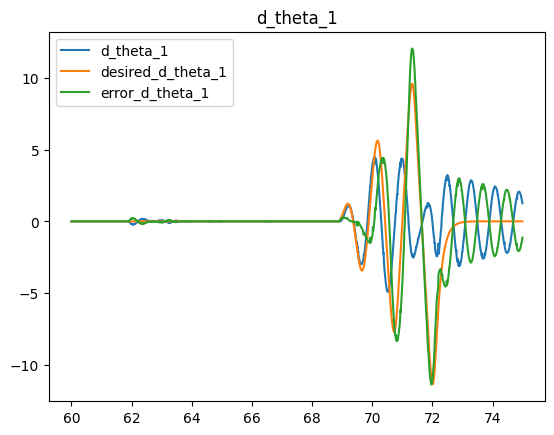

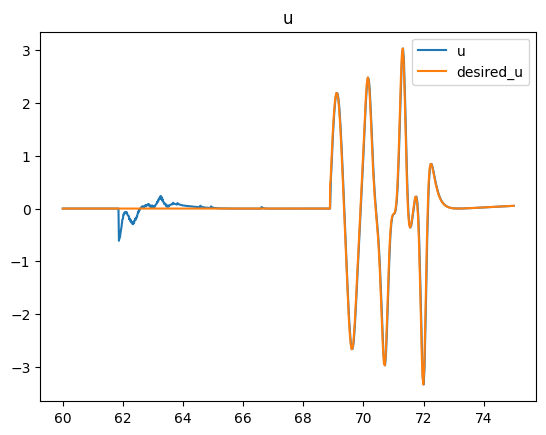

In [118]:
df = df[(df['time'] >= 60) & (df['time'] <= 75)]

time = df['time']
columns = ["s", "d_s", "theta_1", "d_theta_1"]
for column_name in columns:
    mod_pi = column_name.startswith("theta")
    desired_column_name = f"desired_{column_name}"
    error_column_name = f"error_{column_name}"
    column = df[column_name].to_numpy()
    desired_column = df[desired_column_name].to_numpy()
    error_column = df[error_column_name].to_numpy()
    if mod_pi:
        column = np.unwrap(column)
        desired_column = np.unwrap(desired_column)

    plt.plot(time, column, label=column_name)
    plt.plot(time, desired_column, label=desired_column_name)
    plt.plot(time, error_column, label=error_column_name)
    plt.legend()
    plt.title(column_name)
    plt.show()

plt.title("u")
plt.plot(time, df['u'], label='u')
plt.plot(time, df['desired_u'], label='desired_u')
plt.legend()

In [122]:
states = np.array(df[["s", "d_s", "theta_1", "d_theta_1"]])
desired_states = np.array(df[["desired_s", "desired_d_s", "desired_theta_1", "desired_d_theta_1"]])

last_update = perf_counter()
env = CartPoleEnv(system, dt, rk4_step)
for state, desired_state in zip(states, desired_states):
    env.render(state, desired_state)
    while perf_counter() - last_update < dt:
        pass
    last_update = perf_counter()
env.close()

In [120]:

theta_1 = df['theta_1'].to_numpy()[1:-1]
d_theta_1 = df['d_theta_1'].to_numpy()[1:-1]
dd_theta_1 = df['d_theta_1'].diff().to_numpy()[1:-1]/dt

X = d_theta_1
dd_s = df['u'].to_numpy()[1:-1]
y = m1*l1/2*(g*np.sin(theta_1)-dd_s*np.cos(theta_1)-7*l1/2/3*dd_theta_1)

model = LinearRegression().fit(X.reshape(-1, 1), y)
print(model.coef_, model.intercept_)

[-0.00244534] -0.000351615042869892


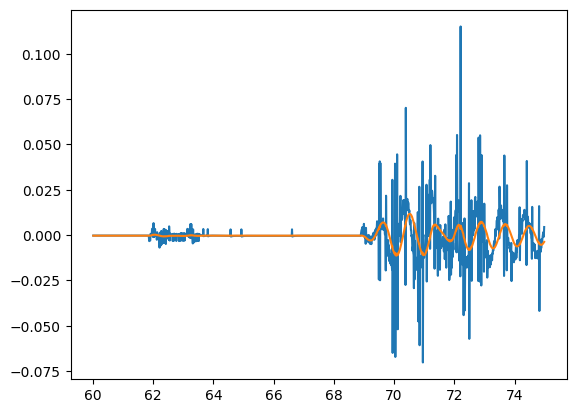

In [121]:
y_calc = model.predict(X.reshape(-1, 1))
time = time[1:-1]
plt.plot(time, y, label='y')
plt.plot(time, y_calc, label='y_calc')